In [31]:
import os
import sys

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

sys.path.append('../')
sys.path.append('../src')
from src import utils
from src import generators
import imp



In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"

In [46]:
if torch.tensor(np.zeros((0,3,3,3))).shape[0] == 0:
    print("df")

df


# Models

## Base Mode - CNN_1

In [3]:
class MVCNN(nn.Module):
    
    def __init__(self, num_classes=None):
        
        super(MVCNN,self).__init__()
        pad = 1
        
        self.cnn = nn.Sequential(nn.BatchNorm2d(1),
                                     nn.Conv2d(1,32,3,padding=pad),
                                     nn.ReLU(),
                                     nn.BatchNorm2d(32),
                                     nn.Conv2d(32,32,3,padding=pad),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2,2), 
        
                                     nn.BatchNorm2d(32),
                                     nn.Conv2d(32,64,3,padding=pad),
                                     nn.ReLU(),
                                     nn.BatchNorm2d(64),
                                     nn.Conv2d(64,64,3,padding=pad),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2,2),
                                     
                                     nn.BatchNorm2d(64),
                                     nn.Conv2d(64,128,3,padding=pad),
                                     nn.ReLU(),
                                     nn.BatchNorm2d(128),
                                     nn.Conv2d(128,128,3,padding=pad),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2,2),
        
                                     nn.BatchNorm2d(128),
                                     nn.Conv2d(128,256,3,padding=pad),
                                     nn.ReLU(),
                                     nn.BatchNorm2d(256),
                                     nn.Conv2d(256,256,3,padding=pad),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2,2), 
        
                                     nn.BatchNorm2d(256),
                                     nn.Conv2d(256,256,3,padding=pad),
                                     nn.ReLU(),
                                     nn.BatchNorm2d(256),
                                     nn.Conv2d(256,256,3,padding=pad),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2,2),
                                     
                                     nn.BatchNorm2d(256),
                                     nn.Conv2d(256,512,3,padding=pad),
                                     nn.ReLU(),
                                     nn.BatchNorm2d(512),
                                     nn.Conv2d(512,512,3,padding=pad),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2,2))
  
        self.fc1 = nn.Sequential(nn.Linear(8192, 1024), 
                                     nn.ReLU(),
                                     nn.Dropout(0.8),
                                     nn.Linear(1024, 96),
                                     nn.ReLU(),
                                     nn.Dropout(0.9),
                                     nn.Linear(96, 1))

        self.fc2 = nn.Sequential(nn.Linear(8192, 4096), 
                                     nn.ReLU(),
                                     nn.Dropout(0.8),
                                     nn.Linear(4096, 4096),
                                     nn.ReLU(),
                                     nn.Dropout(0.9),
                                     nn.Linear(4096, num_classes))
        
    def forward(self, x, batch_size, mvcnn=True):
        
        if mvcnn:
            view_pool = []
            # Assuming x has shape (x, 1, 299, 299)
            for n, v in enumerate(x):
                v = v.unsqueeze(0)
                v = self.cnn(v)
                v = v.view(v.size(0), 512 * 4* 4)

            pooled_view = view_pool[0]
            for i in range(1, len(view_pool)):
                pooled_view = torch.max(pooled_view, view_pool[i])

            output = self.fc(pooled_view)
        
        else:

            x = self.cnn(x)
            x = x.view(-1, 512 * 4* 4)
            output = self.fc2(x)
    
        return output


Since patients have varying images, create single images where the channels occupy the slices of the patient

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mvcnn = MVCNN().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(mvcnn.parameters(), lr=0.0003)

TypeError: new() received an invalid combination of arguments - got (NoneType, int), but expected one of:
 * (torch.device device)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mNoneType[0m, [31;1mint[0m)
 * (object data, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mNoneType[0m, [31;1mint[0m)


In [5]:
file_path = '/home/alex/Dataset 1/Dataset - 1.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')

edss = df['EDSS'].tolist()
p_id = df['Sequence_id'].tolist()
channels = 1
resize = 299
normalization = 'min-max'

patient_information = [(p_id[i], edss[i]) for i in range(df.shape[0])]
train_patient_information = patient_information[:int(0.9*len(patient_information))]
valid_patient_information = patient_information[int(0.9*len(patient_information)):]
base_DatabasePath = '/home/alex/Dataset 1'

In [19]:
generator_inst = generators.SEPGenerator(base_DatabasePath, 
                                                channels=channels,
                                                resize=resize,
                                                normalization=normalization)

train_generator = generator_inst.generator(train_patient_information)
valid_generator = generator_inst.generator(valid_patient_information)

#dataloader = torch.utils.data.DataLoader(train_generator, batch_size=1, shuffle=True)

In [20]:
valid_iterations

48

In [21]:
total_loss = 0
train_iterations = 100
valid_iterations = len(valid_patient_information)
epochs = 5

for epoch in range(epochs):
    total_TrainLoss = 0

    for t_m, t_item in enumerate(train_generator):

        image_3D, label = torch.tensor(t_item[0], device=device).float(), torch.tensor(t_item[1], device=device).float()
        output = mvcnn(image_3D, 1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_TrainLoss += loss

        if not (t_m+1)%50:
            print("On_Going_Epoch : {} \t | Iteration : {} \t | Training Loss : {}".format(epoch+1, t_m+1, total_TrainLoss/(t_m+1)))

        if (t_m+1) == train_iterations:
            total_ValidLoss = 0

            with torch.no_grad():
                for v_m, v_item in enumerate(valid_generator):
                    image_3D, label = torch.tensor(v_item[0], device=device).float(), torch.tensor(v_item[1], device=device).float()
                    output = mvcnn(image_3D, 1)
                    total_ValidLoss += criterion(output, label)
                    print(total_ValidLoss)
                    if (v_m + 1) == valid_iterations:
                        break
                    
            print("Epoch : {} \t | Training Loss : {} \t | Validation Loss : {} ".format(epoch+1, total_TrainLoss/(t_m+1), total_ValidLoss/(v_m+1)) )                   

            torch.save(mvcnn, './' + 'vgg_' + str(epoch) + '.pkl')
            break

On_Going_Epoch : 1 	 | Iteration : 50 	 | Training Loss : 4511.05859375
On_Going_Epoch : 1 	 | Iteration : 100 	 | Training Loss : 2339.1357421875
tensor(7.8825, device='cuda:0')
tensor(7.8826, device='cuda:0')
tensor(8.5348, device='cuda:0')
tensor(10.2445, device='cuda:0')
tensor(18.1271, device='cuda:0')
tensor(18.1641, device='cuda:0')
tensor(19.9259, device='cuda:0')
tensor(20.5781, device='cuda:0')
tensor(20.6151, device='cuda:0')
tensor(28.4977, device='cuda:0')
tensor(203.7557, device='cuda:0')
tensor(211.6382, device='cuda:0')
tensor(970.9899, device='cuda:0')
tensor(985.4875, device='cuda:0')
tensor(999.9852, device='cuda:0')
tensor(1000.0223, device='cuda:0')
tensor(1000.0593, device='cuda:0')
tensor(1820.6040, device='cuda:0')
tensor(1831.5441, device='cuda:0')
tensor(1842.4841, device='cuda:0')
tensor(1853.4242, device='cuda:0')
tensor(1864.3643, device='cuda:0')
tensor(1864.4012, device='cuda:0')
tensor(1864.4382, device='cuda:0')
tensor(1872.3208, device='cuda:0')
tensor

NameError: name 'exception' is not defined

In [16]:
total_ValidLoss

0

'./vgg_9'

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
c = torch.randn(90, 512, 4, 4).to(device)

In [7]:
#torch.randn(90, 1, 299, 299)
for n,v in enumerate(c):
    
    v = v.view(1, 512*4*4).to(device)
    print(n)
    if n:
        pooled_view = torch.max(pooled_view, v).to(device)
    else:
        pooled_view = v.to(device)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


# Augmenter

In [ ]:
def generate_images(image, transformation='original', angle=30):
    """
    Function to generate images based on the requested transfomations
    Args:
    - image             (nd.array)  : input image array
    - transformation    (str)       : image transformation to be effectuated
    - angle 		(int)	    : rotation angle if transformation is a rotation
    Returns:
    - trans_image       (nd.array)  : transformed image array
    """

    def rotateImage(image, angle):
        """
        Function to rotate an image at its center
        """
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
        return result
    
    # Image transformations
    if transformation == 'original':
        trans_image = image
    elif transformation == 'flip_v':
        trans_image = cv2.flip(image, 0)
    elif transformation == 'flip_h':
        trans_image = cv2.flip(image, 1)
    elif transformation == 'flip_vh':
        trans_image = cv2.flip(image, -1)
    elif transformation == 'rot_c':
        trans_image = rotateImage(image, -angle)
    elif transformation == 'rot_ac':
        trans_image = rotateImage(image, angle)
    else:
        raise ValueError("In valid transformation value passed : {}".format(transformation))

    return trans_image

In [ ]:
"""
The agumenter ought to be able to do the following:
- Get list of patient paths and their respective scores (make sure to do the validation and test splits before)
    - Select a random augmentation (flag='test')
    - Select a patient path and his/her corresponding score
    - With each .dcm file do following: 
        - read image
        - normalized image
        - resize image
        - get percentage of white matter (%, n) and append to list
        - transform image
        - store in an array
    - yield image_3D (top 70 images with white matter), label
"""

In [ ]:
def SEP_generator(object):
    
    def __init__(self, 
                 resize,
                 normalization,
                 transformations)
    
    

In [8]:
import imgaug as ia
from imgaug import augmenters as iaa

In [9]:
import imgaug as ia
from imgaug import augmenters as iaa

class ImageBaseAug(object):
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        self.seq = iaa.Sequential(
            [
                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                sometimes(iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5))),
                # Add gaussian noise to some images.
                sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
                # Add a value of -5 to 5 to each pixel.
                sometimes(iaa.Add((-5, 5), per_channel=0.5)),
                # Change brightness of images (80-120% of original value).
                sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.5)),
                # Improve or worsen the contrast of images.
                sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)),
            ],
            # do all of the above augmentations in random order
            random_order=True
        )

    def __call__(self, sample):
        seq_det = self.seq.to_deterministic()
        image, label = sample['image'], sample['label']
        image = seq_det.augment_images([image])[0]
        return {'image': image, 'label': label}

# Trails (Pytorch)

In [1]:
import os
import torch
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [2]:
## TENSORS

# create an 'un-initialized' matrix
x = torch.empty(5, 3)
print(x)

# construct a randomly 'initialized' matrix
x = torch.rand(5, 3)
print(x)

# construct a matrix filled with zeros an dtype=long
x = torch.zeros(5, 3, dtype=torch.long)
print(x)

# construct a tensor from data
x = torch.tensor([[5.5, 3]])
print(x)

# Create a tensor based on existing tensor
x = x.new_ones(5, 3, dtype=torch.double)
print(x)
x = torch.randn_like(x, dtype=torch.float)
print(x)

tensor([[7.0976e+22, 1.8515e+28, 4.1988e+07],
        [3.0357e+32, 2.7224e+20, 7.7782e+31],
        [4.7429e+30, 1.3818e+31, 1.7225e+22],
        [1.4602e-19, 1.8617e+25, 1.1835e+22],
        [4.3066e+21, 6.3828e+28, 1.4603e-19]])
tensor([[0.3337, 0.6211, 0.9639],
        [0.1094, 0.2283, 0.4058],
        [0.6591, 0.8595, 0.0782],
        [0.7474, 0.8065, 0.0429],
        [0.4577, 0.5123, 0.5054]])
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])
tensor([[5.5000, 3.0000]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
tensor([[ 1.6513, -0.3198, -1.5212],
        [-1.4167, -0.5110, -1.1456],
        [ 0.9274,  2.0594, -1.2510],
        [ 0.0256, -0.2712, -0.4079],
        [-0.0939, -1.1903,  1.3387]])


In [3]:
## OPERATIONS

# Addition syntax 1
y = torch.rand(5, 3)
print(x + y)

# Addition syntax 2
print(torch.add(x, y))

# Addtion output towards a tensor
result = torch.empty(5,3)
torch.add(x, y, out=result)
print(result)

# Addition in place
y.add(x)
print(y)

# Any operation that mutates a tensor in-place is post-fixed with an _.
x.copy_(y)
x.t_()

# Resizing tensors
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1,8)
print(x.size(), y.size(), z.size())

# Use get value off a one element tensor
x = torch.randn(1)
print(x)
print(x.item())



tensor([[ 2.3659, -0.1678, -0.7175],
        [-0.5564, -0.1421, -0.5350],
        [ 1.0469,  3.0384, -0.9379],
        [ 0.9468,  0.2249,  0.0415],
        [ 0.0893, -0.8271,  1.6718]])
tensor([[ 2.3659, -0.1678, -0.7175],
        [-0.5564, -0.1421, -0.5350],
        [ 1.0469,  3.0384, -0.9379],
        [ 0.9468,  0.2249,  0.0415],
        [ 0.0893, -0.8271,  1.6718]])
tensor([[ 2.3659, -0.1678, -0.7175],
        [-0.5564, -0.1421, -0.5350],
        [ 1.0469,  3.0384, -0.9379],
        [ 0.9468,  0.2249,  0.0415],
        [ 0.0893, -0.8271,  1.6718]])
tensor([[0.7146, 0.1521, 0.8037],
        [0.8603, 0.3689, 0.6106],
        [0.1195, 0.9790, 0.3132],
        [0.9212, 0.4961, 0.4493],
        [0.1832, 0.3632, 0.3331]])
torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])
tensor([1.0785])
1.0785350799560547


In [4]:
## NUMPY BRIDGE

# Torch tensor to numpy array
a = torch.ones(5)
b = a.numpy()
print(a)
print(b)

a.add_(1)
print(a)
print(b)


# Numpy array to torch tensor
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

tensor([1., 1., 1., 1., 1.])
[1. 1. 1. 1. 1.]
tensor([2., 2., 2., 2., 2.])
[2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


In [5]:
## USING CUDA

if torch.cuda.is_available():
    device = torch.device("cuda")           # Cuda device object
    y = torch.ones_like(x, device=device)   # Directly creates a tensor on GPU
    x = x.to(device)                        # 
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))
    

tensor([2.0785], device='cuda:0')
tensor([2.0785], dtype=torch.float64)


In [6]:
"""
AUTO-GRAD
- The autograd package provides automatic differntation for all
opeations on tensors. 
- A define-by-run framework i.e backprop defined by how code 
is run and every single iteration can be different.

TENSOR
- torch.tensor is the central class of the 'torch' package.
- If  one sets attribute '.requires_grad()' as 'True', all 
operations on it are tracked. 
- When computations are finished one can call'backward()' 
and have all the gradients computed.
- Gradient of a tensor is accumulated into '.grad' attribute.
- To stop tensor from tracking history, call '.detach()' to detach 
it from computation history and prevent future computation 
from being tracked
- To prevent tacking histroy and using memory, wrap the code 
block in 'with torch.no_grad()'. Helpful when evaluating a model
cause model has trainable parameters with 'requires_grad=True'
- 'Function' class is very important for autograd implementation
- 'Tensor' and 'Function' are interconnected and buid up an acyclic
graph that encodes a complete history of computation.
- Each tensor has a '.grad_fn' attribute that references a 'Function'
that has created the 'Tensor' (except for tensors created by user)
- To compute derivates, '.backward()' is called on a Tensor. If 
tensor is a scalar, no arguments ought to be passed to '.backward()'
if not, a 'gradient' argument ought to be specified.
"""

"\nAUTO-GRAD\n- The autograd package provides automatic differntation for all\nopeations on tensors. \n- A define-by-run framework i.e backprop defined by how code \nis run and every single iteration can be different.\n\nTENSOR\n- torch.tensor is the central class of the 'torch' package.\n- If  one sets attribute '.requires_grad()' as 'True', all \noperations on it are tracked. \n- When computations are finished one can call'backward()' \nand have all the gradients computed.\n- Gradient of a tensor is accumulated into '.grad' attribute.\n- To stop tensor from tracking history, call '.detach()' to detach \nit from computation history and prevent future computation \nfrom being tracked\n- To prevent tacking histroy and using memory, wrap the code \nblock in 'with torch.no_grad()'. Helpful when evaluating a model\ncause model has trainable parameters with 'requires_grad=True'\n- 'Function' class is very important for autograd implementation\n- 'Tensor' and 'Function' are interconnected an

In [7]:
## TENSORS

# Create tenor to track all operations
x = torch.ones(2,2, requires_grad=True)
print(x)
y = x + 2
print(y)
z = y * y * 3
out = z.mean()
print(z, out)

## GRADIENTS

# Peforming backprop on 'out'
out.backward()
print(x.grad)

# An example of vector-Jacobian product
x = torch.randn(3, requires_grad=True)
y = x * 2
while y.data.norm() < 1000:
    y = y * 2
print(y)
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)
print(x.grad)

# Stop autograd from tracking history on Tensors 
# with .requires_grad=True 
print(x.requires_grad)
print((x ** 2).requires_grad)
with torch.no_grad():
    print((x**2).requires_grad)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([ -388.7856,   198.8780, -1300.0267], grad_fn=<MulBackward0>)
tensor([2.0480e+02, 2.0480e+03, 2.0480e-01])
True
True
False


In [32]:
image.requires_grad_(True)

TypeError: 'bool' object is not callable

In [33]:
image

tensor([[[[ 1.5959, -1.3052, -0.6488,  ..., -1.0006, -1.8247,  1.6126],
          [-1.0831,  1.6789, -0.2507,  ...,  1.9883,  0.0440, -1.0205],
          [ 1.3978, -0.5599,  0.9209,  ...,  1.3029,  1.1875, -3.1398],
          ...,
          [-0.0280, -1.8147,  0.7449,  ..., -1.1217, -1.8393, -0.7728],
          [-0.6970, -0.3968,  0.6772,  ..., -1.6072,  0.3949,  0.0676],
          [-0.9794,  0.6049, -0.0923,  ...,  0.6333, -1.1131,  0.2632]]]],
       device='cuda:0')

In [8]:
"""
## NEURAL NETWORKS

- Can be constructed using 'torch.nn' package
- 'nn' depends on 'autograd' to define models and differentiate
them. 
- 'nn.Module' contains layers and a method forward(input) that 
returns the 'output'.
- Training procedure:
    - Define neural network that has some learnable parameter
    - Iterate over a dataset of inputs
    - Process input through the network
    - Compute loss
    - Propagate gradients back into the network's parameters
    - Update weights

"""

"\n## NEURAL NETWORKS\n\n- Can be constructed using 'torch.nn' package\n- 'nn' depends on 'autograd' to define models and differentiate\nthem. \n- 'nn.Module' contains layers and a method forward(input) that \nreturns the 'output'.\n- Training procedure:\n    - Define neural network that has some learnable parameter\n    - Iterate over a dataset of inputs\n    - Process input through the network\n    - Compute loss\n    - Propagate gradients back into the network's parameters\n    - Update weights\n\n"

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        # An affine operation 
        self.fc1 = nn.Linear(16*6*6, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
        
    def num_flat_features(self, x):
        
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
            
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [12]:
params = list(net.parameters())
len(params)

10

In [13]:
params

[Parameter containing:
 tensor([[[[-0.2323, -0.2449, -0.2866],
           [-0.1146,  0.0728,  0.2426],
           [-0.0343, -0.0685, -0.3318]]],
 
 
         [[[-0.2328,  0.0704,  0.2253],
           [-0.1530, -0.0996,  0.2698],
           [ 0.2488, -0.3037, -0.2377]]],
 
 
         [[[ 0.1622, -0.2684,  0.2374],
           [ 0.0469,  0.3276,  0.0163],
           [-0.3135, -0.2353,  0.0664]]],
 
 
         [[[ 0.3103, -0.2125,  0.0187],
           [-0.1651, -0.1872,  0.2033],
           [ 0.0383, -0.2781, -0.0507]]],
 
 
         [[[-0.1093, -0.0654,  0.1340],
           [-0.3097,  0.1266, -0.1893],
           [ 0.0642,  0.1337, -0.2085]]],
 
 
         [[[-0.1382,  0.3026, -0.3094],
           [-0.2960,  0.0430,  0.1208],
           [-0.1313, -0.1435, -0.1754]]]], requires_grad=True),
 Parameter containing:
 tensor([-0.2984,  0.2190, -0.1588, -0.0237, -0.3073,  0.2563],
        requires_grad=True),
 Parameter containing:
 tensor([[[[ 5.0677e-02, -7.0059e-03,  1.2598e-01],
           [

In [12]:
# Pass tensor throught the network
input = torch.randn(1,1, 32, 32)
out = net(input)
print(out)

# Zero gradient buffer of all parameters and backprops with random gradient 
net.zero_grad()
out.backward(torch.randn(1, 10))

# Calculating loss
output = net(input)
target = torch.randn(10)
target = target.view(1, -1)
criterion = nn.MSELoss()
loss = criterion(output, target)
print(loss)

# Backprop
#loss.backward()
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)
loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

tensor([[ 0.0743, -0.0684, -0.0404,  0.1276,  0.0089, -0.1240,  0.0720, -0.0330,
         -0.1403,  0.0009]], grad_fn=<AddmmBackward>)
tensor(0.7660, grad_fn=<MseLossBackward>)


In [14]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.305
[1,  4000] loss: 2.304
[1,  6000] loss: 2.304
[1,  8000] loss: 2.304
[1, 10000] loss: 2.305
[1, 12000] loss: 2.304
[2,  2000] loss: 2.304
[2,  4000] loss: 2.305
[2,  6000] loss: 2.304
[2,  8000] loss: 2.304
[2, 10000] loss: 2.305
[2, 12000] loss: 2.304
Finished Training


In [1]:
epochs = 10
iterations = 100

In [11]:
for epoch in range(epochs):
    total_TrainLoss = 0
    t_m = 0
    
    while True:
        
        t_m += 1
        total_TrainLoss += 10
        
        
#     for t_m, t_item in enumerate(train_generator):

#         image_3D, label = torch.tensor(t_item[0], device=device).float(), torch.tensor(t_item[1], device=device).float()
#         output = net1(image_3D, 1)
#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()

#         total_TrainLoss += loss

        if not (t_m+1)%10:
            print("Epoch : {} | Iteration : {} | Training Loss : {}".format(epoch+1, t_m+1, total_TrainLoss/(t_m)))

        if t_m+1 == iterations:
            total_ValidLoss = 100

#             with torch.no_grad():
#                 for v_m, item in enumerate(valid_generator):
#                     image_3D, label = torch.tensor(v_item[0], device=device).float(), torch.tensor(v_item[1], device=device).float()
#                     output = net1(image_3D, 1)
#                     total_ValidLoss += criterion(output, label)

            print("Epoch : {} | Training Loss : {} | Validation Loss : {} ".format(epoch+1, total_TrainLoss/(t_m+1), total_ValidLoss/(9+1)) )                   
            break




Epoch : 1 | Iteration : 10 | Training Loss : 10.0
Epoch : 1 | Iteration : 20 | Training Loss : 10.0
Epoch : 1 | Iteration : 30 | Training Loss : 10.0
Epoch : 1 | Iteration : 40 | Training Loss : 10.0
Epoch : 1 | Iteration : 50 | Training Loss : 10.0
Epoch : 1 | Iteration : 60 | Training Loss : 10.0
Epoch : 1 | Iteration : 70 | Training Loss : 10.0
Epoch : 1 | Iteration : 80 | Training Loss : 10.0
Epoch : 1 | Iteration : 90 | Training Loss : 10.0
Epoch : 1 | Iteration : 100 | Training Loss : 10.0
Epoch : 1 | Training Loss : 9.9 | Validation Loss : 10.0 
Epoch : 2 | Iteration : 10 | Training Loss : 10.0
Epoch : 2 | Iteration : 20 | Training Loss : 10.0
Epoch : 2 | Iteration : 30 | Training Loss : 10.0
Epoch : 2 | Iteration : 40 | Training Loss : 10.0
Epoch : 2 | Iteration : 50 | Training Loss : 10.0
Epoch : 2 | Iteration : 60 | Training Loss : 10.0
Epoch : 2 | Iteration : 70 | Training Loss : 10.0
Epoch : 2 | Iteration : 80 | Training Loss : 10.0
Epoch : 2 | Iteration : 90 | Training Los

In [1]:
# Dependencies
import cv2
import numpy as np
import pandas as pd

import os
import png
import glob
import pickle
import random
from tqdm import tqdm

import pydicom
from pydicom.data import get_testdata_files

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
darkmatter_idx = []
patient = glob.glob("/home/alex/Dataset2/13205/*.dcm")
for n, dcm_files in enumerate(patient):
    dataset = pydicom.dcmread(dcm_files)       	# Read dcm file
    image = dataset.pixel_array
    row, col = image.shape
    dark_matter = np.sum(image == 0) / (row*col)
    darkmatter_idx.append((dark_matter, n))



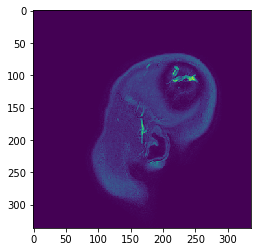

In [29]:
plt.imshow(image)

In [30]:
[item[1] for item in sorted(darkmatter_idx)][:70] 


[239,
 99,
 8,
 210,
 201,
 120,
 69,
 35,
 250,
 150,
 121,
 1,
 13,
 68,
 154,
 159,
 226,
 91,
 103,
 168,
 128,
 170,
 209,
 48,
 50,
 97,
 134,
 102,
 122,
 166,
 107,
 130,
 138,
 52,
 40,
 33,
 20,
 104,
 63,
 246,
 192,
 179,
 236,
 206,
 147,
 53,
 108,
 77,
 125,
 84,
 98,
 175,
 116,
 184,
 28,
 11,
 81,
 41,
 27,
 190,
 44,
 85,
 167,
 67,
 26,
 243,
 256,
 205,
 113,
 3]

In [ ]:
to